# Project: Investigation of factors associated to Diabetes in Brazilian cohort

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>

## Introduction

In this analysis I will investigate the "no-show appointments" dataset from kaggle. I will investigate what variables are related to Diabetes. My assumptions prior to looking at the data would be that individuals who suffer from diabetes are more liekly to be male, old and suffering from hypertension. 

In [48]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic

#magic for matplotlib
%matplotlib inline

<a id='wrangling'></a>

## Data Wrangling



### General Properties

It appears that the dataframe has 110527 rows and 14 columns. There appear to be no missing values.  

The describe function does show that some age values are unreasonable, with a minimum of -1 and max of 115. This needs to be addressed. For this study it seems reasonable to focus on adults between the ages of 18 and 65. Children and the Eldery are affected quite differently by disease.  

There are 110527 unique appointment IDs, which is good since they need to be unique.  

There are only 62299 Patient Ids indicating that some patients have multiple appointments. We only need one record per patient to look at the relationship between diabetes, age, gender and hyptertension.  

A quick check was performed to see if Diabetes or Hypertension status changed for any individuals. This was done by calculating the variance after grouping by patient. If an individual gets a new diagnosis variance would go above 0. This was not seen anywhere.  

The column "Hipertension" should be "Hypertensions". 


Categorical variables are coded as integers or in the case of gender as strings. I prefer to use the pandas categorical data type since that makes it more obvious when I work with it.  

In [49]:
# Load data
df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")


#get info for dataframe. 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [50]:
#describe dataframe
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [51]:
#Check how many unique appointment IDs there are
df["AppointmentID"].nunique()

110527

In [52]:
#Check how many unique patient IDs there are. 
df["PatientId"].nunique()

62299

In [53]:
# Check if for individuals with multiple appointments there is a change in diabetes or hypertension status. 
# It is possible that patients get diagnosed between appointments. 
# Make df2 of varience for all columns grouped by patient id. 
df_pid= df.groupby(by="PatientId").var()
# Select rows with variance above 0 for Diabetes or Hypertension. 
df_pid.loc[(df_pid["Diabetes"] > 0) | (df_pid["Hipertension"] > 0), ]

,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
PatientId,,,,,,,,



### Data Cleaning

In [54]:
# Change column name 
df.rename(columns = {'Hipertension':'Hypertension'}, inplace = True) 

#Subset to individuals between the ages of 18 and 65
df = df.loc[(df["Age"] > 18) & (df["Age"] < 65), ] 

#Remove duplicate patient IDs
df.drop_duplicates(subset = "PatientId", inplace = True)




In [55]:
#Subset to variables of interest
df = df[['Diabetes','Gender', 'Hypertension', 'Age']]

#Change categorical variables to categorical
df[['Diabetes','Gender', 'Hypertension']]=df[['Diabetes','Gender', 'Hypertension']].astype("category")


#Add actual categories for diabetes and hypertension
df["Diabetes"].replace([0,1],["non-Diabetic","Diabetic"],inplace = True)
df["Hypertension"].replace([0,1],["no-Hypertension","Hypertension"],inplace = True)


<a id='eda'></a>

## Exploratory Data Analysis


### Relationship between Diabetes and Hypertension

The boxplot below quite clearly shows that diabetics as a group tend to be older than healthy individuals. This is also true for individuals with hypertension, and individuals with concurrent hypertension and diabetes are the oldest.  

This might mean that old age is a risk factor for both diabetes and hypertension, rather then there being a direct relationship between the two conditions.  

However looking at the contingency table and mosaic plots for diabetes and hypertension shows that out of the 2509 individuals with Diabetes only 635 have diabetes alone, while 1874 have both hypertension and diabetes. The P-value in this case was 0, which is very strong grounds to reject the null hypothesis that the distribution we see is due to random chance.  

We see significantly more Diabetics with hypertension than without, but when looking at hypertension there is actually a larger group that do not have Diabetes. It is known that diabetes is a risk factor for hypertension, and this data fits in with the medical literature. 

Text(0.5, 1.0, 'Boxplot of Diabetes vs Age split by Hypertension status.')

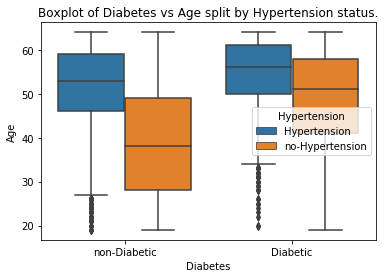

In [56]:
#Boxplot of diabetes vs age  broken down by hypertension.  
bp_dvh = sns.boxplot(x="Diabetes", y="Age", hue="Hypertension",data=df)
plt.title("Boxplot of Diabetes vs Age split by Hypertension status.")


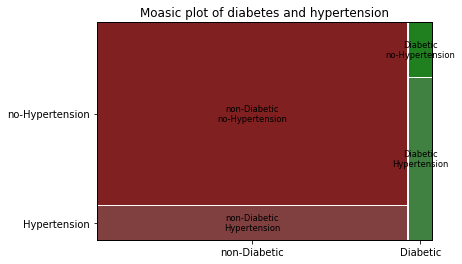

Diabetes         Diabetic  non-Diabetic
Hypertension                           
Hypertension         1874          5431
no-Hypertension       635         28910
p_value : 0.0
Odds Ratio : 15.709564660153072


In [59]:
# make diabetes & hypertension contingency tabel for use in fisher exact test. 
tab_dh = pd.crosstab(df['Hypertension'],df['Diabetes'])

# Fisher exact test 
odds_dh, p_val_dh = stats.fisher_exact(tab_dh)


mosaic(df,["Diabetes","Hypertension"],title = "Moasic plot of Diabetes and Hypertension")
plt.show()

#print crosstab and stats
print(tab_dh)
print ("p_value :", p_val_dh)
print ("Odds Ratio :", odds_dh)

### Does Diabetes affect Men and Women at similair rates and ages? 

When it comes to Gender it seems that women and men are affected at similair rates and in older age. Diabetics tend to be in their 50s and 60s regardless of gender and the proportion of female diabetics is similair to that of male, given the size of their respective populations. 

The mosaic plot shows that diabetes status proporitions are very similair across genders.
A fishers exact test was performed with the p_value being 0.059. Using a normal p-vaulue cutoff of 0.05 we should not reject the null hypothesis, which is that gender is not significantly associated to diabetes. 

Gender            F      M
Diabetes                  
Diabetic       1699    810
non-Diabetic  23875  10466
p_value : 0.05944536168671716
Odds Ratio : 0.9194872471074914


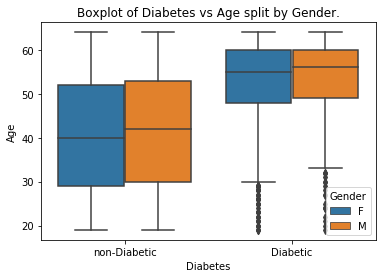

In [36]:
#Boxplot of Diabetes vs age broken down by Gender.  
bp_dg = sns.boxplot(x="Diabetes", y="Age", hue="Gender",data=df)
bp_dg = plt.title("Boxplot of Diabetes vs Age split by Gender.")

# make diabetes & hypertension contingency tabel for use in fisher exact test. 
tab_dg = pd.crosstab(df['Diabetes'], df['Gender'])

# Fisher exact test 
odds_dg, p_val_dg = stats.fisher_exact(tab_dg)



print(tab_dg)
print ("p_value :", p_val_dg)
print ("Odds Ratio :", odds_dg)

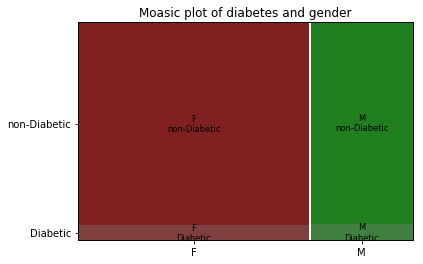

In [46]:
mosaic(df,["Gender","Diabetes"],title = "Moasic plot of diabetes and gender")
plt.show()

<a id='conclusions'></a>

## Conclusions

In this project I briefly looked at how age, gender and hypertension are associated with Diabetes in a brazilien dataset.  
The results suggest that diabetics tend to be older, and have higher rates of hypertension. I could not detect a significant relationship between gender and diabetes.  

A major limiation of of this project is that the data is form a study looking at missed appointments not diabetes. Therefore it was not possible to distinguish between type 1 and type 2 diabetes or other diabetes subtypes. The cohort is also not representative of the general population since this is studying missed appointments, it can be assumed that most individuals are suffering from some condition. Since medical problems can have complex relationships results could be affected by the lack of a true healthy control group.

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0